# Objectives

1. Sampling Bias
    - A. Full
    - B. Russia "Knockout"
    - C. Germany "Knockout"
1. Geocoding Bias
1. Drawing Bias

---
# Setup

## Modules

In [1]:
import os
import dill
import copy
import math

from Bio import Phylo
import pandas as pd
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib import lines, patheffects, animation

## Variables

In [2]:
from config import *

# Custom script variables
SCRIPT_NAME = "geo_bias"
PREV_DIR_NAME = "mugration"
PREV_SCRIPT_NAME = "mugration_model"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "Name"

## File Paths

In [3]:
config_dir = os.path.join(project_dir, "config")
results_dir = os.path.join(project_dir, "results")

outdir       = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
#tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + "_timetree.treetime.obj")
#tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_path    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + "_timetree.nwk")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))

# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_latlon.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

#print("tree_dill:\t", tree_dill)
#print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "geo_bias"

aln path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter5.aln
auspice_latlon_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_latlon.tsv
auspice_colors_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_colors.tsv
auspice_config_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/config/auspice_config.json
auspice_remote_dir_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/
outdir: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/geo_bias/all/chromosome_filter5


## Import Tree

In [4]:
# with open(tree_dill, "rb") as infile:
#     tt = dill.load(infile)
# tt.tree.ladderize(reverse=False)

tree = Phylo.read(tree_path, "newick")
tree.ladderize(reverse=False)

## Import Dataframe

In [5]:
# with open(tree_df_dill, "rb") as infile:
#     tree_df = dill.load(infile)
# display(tree_df)

tree_df = pd.read_csv(tree_df_path, sep='\t')
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

# Import Colors

In [6]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)

# Add sizes
colors_df["Size"] = [NO_DATA_CHAR for i in range(0,len(colors_df))]
i = 0
for attr in list(dict.fromkeys(colors_df["Attribute"])):
    title_attr = attr.replace("_"," ").title().replace(" ","_")
    attr_df =  colors_df[colors_df["Attribute"] == attr]
    for state in attr_df["State"]:
        if attr == "branch_number":
            state = int(state)
        matches = tree_df[tree_df[title_attr] == state]
        colors_df.at[i,"Size"] = len(matches)
        i += 1

display(colors_df)
    
# Convert to dict
colors_dict = {}
sizes_dict = {}
for rec in colors_df.iterrows():
    attr = rec[1]["Attribute"]
    state = rec[1]["State"]
    color = rec[1]["Color"]
    size = rec[1]["Size"]

    if attr not in colors_dict:
        colors_dict[attr] = {}
    if attr not in sizes_dict:
        sizes_dict[attr] = {}        
    colors_dict[attr][state] = color        
    sizes_dict[attr][state] = size

,Attribute,State,Color,Size
0,branch_number,0,#8000ff,210
1,branch_number,3,#00b4ec,12
2,branch_number,4,#80ffb4,15
3,branch_number,2,#ffb462,173
4,branch_number,1,#ff0000,206
...,...,...,...,...
202,province,Midlands,#ff1c0e,1
203,province,State of Mato Grosso,#ff150b,1
204,province,MSila,#ff0e07,1
205,province,La Paz,#ff0704,1


---
# Experiment Prep

- 3 Sources of bias to test:
  1. Sampling
    - geo_filter (All, Region1, Region2, ...)
  1. Geocoding
    - geo_attr (Country, Province)
  1. Connection
    - arrow_style (great circle, arc, straight)
  

In [7]:
# Global Variables
marker_scale = 2
marker_size = 20
branch = "1.PRE"
basemap = cimgt.Stamen('terrain-background')

arbitrary_arc = "arc3,rad=-0.3"
great_circle = "great_circle"

# Experiment Dataframe
columns = ["bias", "geo_attr", "geo_filter_attr", "geo_keep", "geo_remove", "arrow_style", "title"]
experiments = [
    #["Sampling",   "Province", "Country", "All", None,      great_circle, ""],
    #["Sampling",   "Province", "Country", "All", "Russia",  arbitrary_arc, ""],
    #["Sampling",   "Province", "Country", "All", "Germany", arbitrary_arc, ""],   
    ["Geocoding",  "Province", "Country", "All", None,      great_circle, "Geocoding Bias: Province Resolution"],  
    ["Geocoding",  "Country",  "Country", "All", None,      great_circle, "Geocoding Bias: Country Resolution"],
    #["Connection", "Province", "Country", "All", None,      great_circle], 
    #["Connection", "Province", "Country", "All", None,      curved_arrow],     
]

experiment_df = pd.DataFrame()
experiment_df = experiment_df.append(experiments)
experiment_df.columns = columns
display(experiment_df)

,bias,geo_attr,geo_filter_attr,geo_keep,geo_remove,arrow_style,title
0,Geocoding,Province,Country,All,None,great_circle,Geocoding Bias: Province Resolution
1,Geocoding,Country,Country,All,None,great_circle,Geocoding Bias: Country Resolution


### Create the subtree and sub dataframe

In [8]:
clade_df = tree_df[tree_df["Mugration_Branch_Major"] == branch]
clade = tree.common_ancestor(clade_df.index)
parent_node = copy.deepcopy(get_parent(tree, clade.root.name))
parent_rec = tree_df[tree_df.index.str.contains(parent_node.name)]
clade = parent_node
clade_df = clade_df.append(parent_rec)

# Prune clades outside
prune_nodes = []

for c in clade.find_clades(order="postorder"):
    if c.name not in clade_df.index:
        prune_nodes.append(c)
        
for node in prune_nodes:
    if node in clade.find_clades(node):
        try:
            clade.prune(node)
        except AttributeError as e:
            print(e)
            continue

# Clean up dataframe
for node in clade_df.index:
    if node not in [c.name for c in clade.find_clades()]:
        clade_df.drop(node, inplace=True)


display(clade_df)

can't set attribute


,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE427,100,88.1,2.346e-07,black,0.001052,421.403633,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.298620e-08,1.397220,2.148914e-07,1315-09-22,1315.723295,"[1277.0572750664792, 1318.4601112730293]","[743.9427249335208, 702.5398887269707]",9.142302,5283.991552,421.403633,1315.723295,0.000052,False,1,0.999248,7.076729e-03,1.PRE,0.999292,6.846903e-03,1.PRE0,0.398808,1.543887e+00,Russia,0.655249,9.209812e-01,64.686314,97.745306,Tatarstan,0.350106,1.632695e+00,55.448217,50.476359
SAMEA5818806,NA,NA,2.35e-08,grey,0.001052,411.000000,LAI009,[1300:1400],[-721:-621],Russia,Tatarstan,64.6863,97.7453,55.4482,50.4764,Second Pandemic,1.PRE,1.PRE0,SAMEA5818806,KEEP: SRA Ancient,1,1.276070e-09,0.137296,2.680808e-22,1315-09-22,1315.723295,"[1300.0, 1318.2610714923705]","[721.0, 702.7389285076295]",0.000000,5283.991552,411.000000,1350.000000,0.000052,False,1,1.000000,-1.000089e-12,1.PRE,1.000000,-1.000089e-12,1.PRE0,1.000000,-1.000089e-12,Russia,1.000000,-1.000089e-12,64.686314,97.745306,Tatarstan,1.000000,-1.000089e-12,55.448217,50.476359
NODE428,100,97.7,2.346e-07,red,0.001052,431.807266,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.586495e-08,1.706954,2.148911e-07,1322-10-09,1322.771898,"[1288.8041088190141, 1326.8728832201582]","[732.1958911809859, 694.1271167798418]",7.048603,5291.040155,431.807266,1322.771898,0.000052,False,1,1.000000,2.329058e-11,1.PRE,1.000000,2.277747e-11,1.PRE1,0.999998,3.479665e-05,Germany,0.796769,7.008068e-01,51.083420,10.423447,Bavaria,0.915565,4.506905e-01,48.946756,11.403872
NODE429,99,95.4,4.692e-07,red,0.001053,418.448730,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.854963e-08,1.995805,4.297898e-07,1338-02-21,1338.142431,"[1327.5938374426103, 1375.4658081585108]","[693.4061625573897, 645.5341918414892]",15.370533,5306.410689,418.448730,1338.142431,0.000053,False,1,1.000000,8.567376e-08,1.PRE,1.000000,2.209338e-07,1.PRE1,1.000000,9.558136e-07,Germany,0.882693,5.209671e-01,51.083420,10.423447,Bavaria,0.943209,3.223245e-01,48.946756,11.403872
SAMEA7293136,NA,NA,2.346e-07,grey,0.001053,417.000000,COL001,[1300:1400],[-721:-621],Italy,Lazio,42.6384,12.6743,41.9808,12.7662,Second Pandemic,1.PRE,1.PRE1,SAMEA7293136,KEEP: SRA Ancient,1,7.840284e-09,0.843558,2.149584e-07,1363-01-06,1363.014276,"[1350.6889249938997, 1400.0]","[670.3110750061003, 621.0]",24.871845,5331.282534,417.000000,1350.000000,0.000053,False,1,1.000000,-1.000089e-12,1.PRE,1.000000,-1.000089e-12,1.PRE1,1.000000,-1.000089e-12,Italy,1.000000,-9.998669e-13,42.638426,12.674297,Lazio,1.000000,-1.000089e-12,41.980804,12.766231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA5054090,NA,NA,2.624e-07,grey,0.001053,450.000000,Ber45,[1300:1400],[-721:-621],The Netherlands,North Brabant,52.5002,5.74808,51.6018,5.44414,Second Pandemic,1.PRE,1.PRE2,SAMEA5054090,KEEP: SRA A

### Plot Subtree

[]

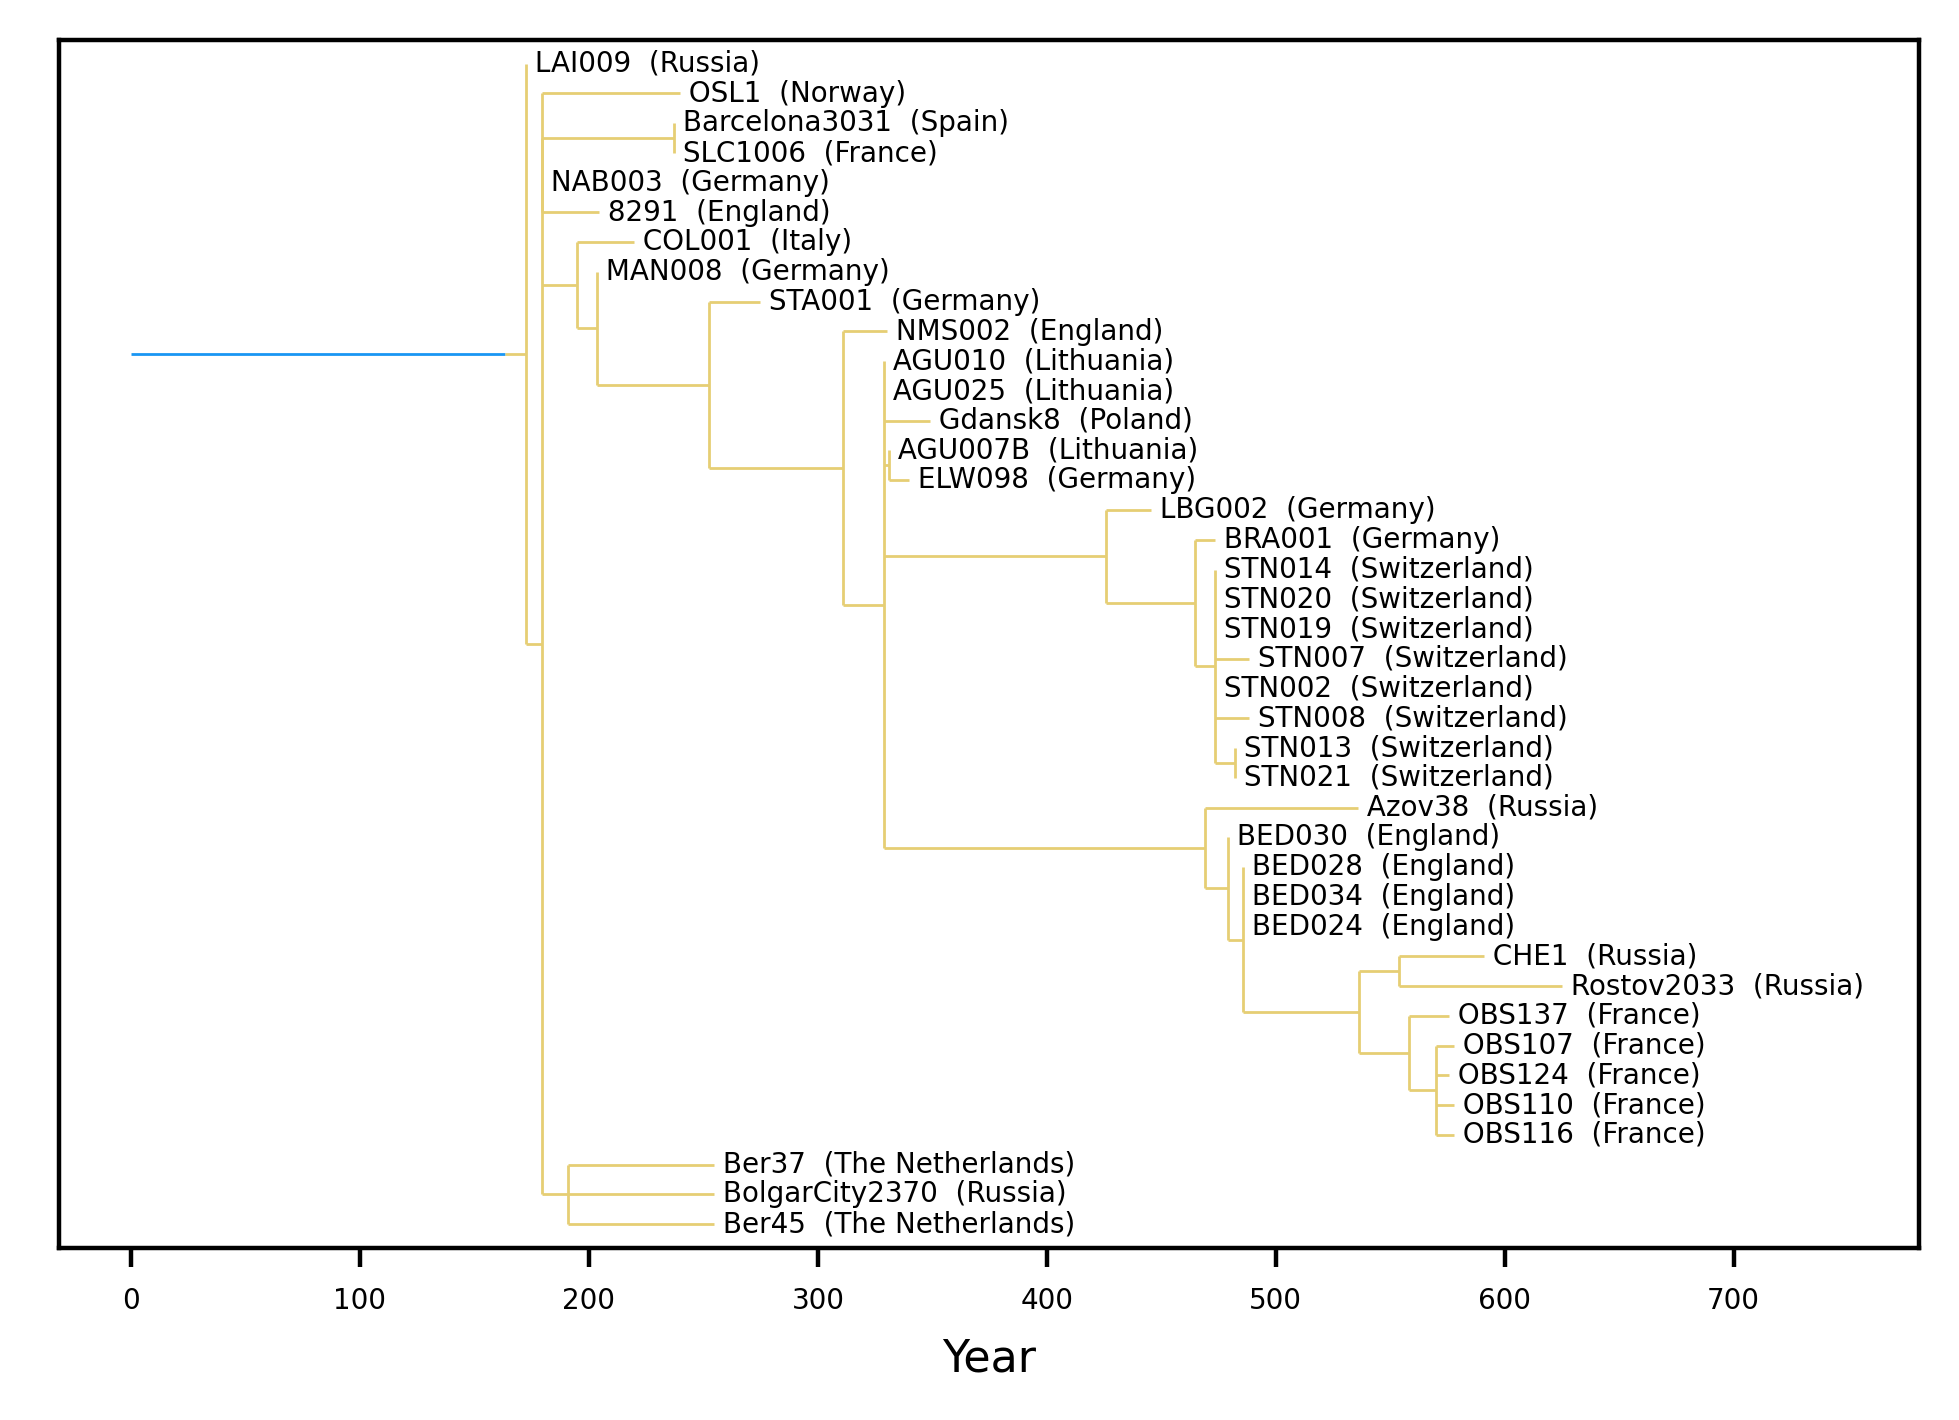

In [9]:
fig_tree, ax_tree = plt.subplots(1, dpi=dpi)

#plt.rc("lines", linewidth=1)

# Color tree
for c in clade.find_clades():
    state = tree_df["Mugration_Branch_Major"][c.name]
    color = colors_dict["branch_major"][state]
    c.color = color


Phylo.draw(clade,
             axes=ax_tree,
             show_confidence=False, 
             label_func = (lambda x: "{} ({})".format(
                     clade_df["Strain"][x.name] + " ", 
                     clade_df["Country"][x.name]) 
                 if x.is_terminal() else ''),
             #label_func = lambda x: x,
             do_show=False,
            )

ax_tree.set_title("")
ax_tree.set_xlabel("Year")
ax_tree.set_ylabel("")
ax_tree.set_yticks([])

---
# Run Experiments

## 2. Geocoding Bias

1. Basemap (Stamen Terrain)
2. Connection Lines
3. Nodes (Samples)
4. Root

## Prep Plotting Data

In [86]:
# Select an experiment
experiment = experiment_df[(experiment_df["bias"] == "Geocoding") & (experiment_df["geo_attr"] == "Province") ]

# Setup variables
exp_tree = copy.deepcopy(clade)
geo_attr = experiment["geo_attr"][0]
exp_df = copy.deepcopy(clade_df)

# Convert dataframe to geopandas
geometry = []
for rec in exp_df.iterrows():
    sample = rec[0]
    x = exp_df["Mugration_" + geo_attr + "_Lon"][sample] 
    y = exp_df["Mugration_" + geo_attr + "_Lat"][sample]
    geometry.append(shapely.geometry.Point(x,y))

exp_gdf = geopandas.GeoDataFrame(exp_df, crs=CRS, geometry=geometry)   

# ---------------------------------------
# Root Data
root_geom = exp_gdf["geometry"][clade.root.name]
root_state = exp_df["Mugration_Branch_Major"][clade.root.name]
root_color = colors_dict["branch_major"][root_state] 
root_marker = lines.Line2D([root_geom.x], 
            [root_geom.y],
            marker="*",
            markerfacecolor=root_color, 
            markeredgecolor="black", 
            markeredgewidth=0.5,
            markersize=10, 
            zorder=4,
        )
    
# ---------------------------------------
# Connections Data
network = tree2network(exp_tree)
network_connect_uniq = []
network_connections = []

for connection in network:
    # Node names
    origin_name = connection[0].name
    dest_name = connection[1].name
    
    # Node Geometry
    origin_geom = exp_gdf["geometry"][origin_name]
    dest_geom = exp_gdf["geometry"][dest_name]
    
    # Aesthetic
    dest_state = exp_df["Mugration_Branch_Major"][dest_name]
    dest_color = colors_dict["branch_major"][dest_state] 
    dest_confidence = exp_df["Mugration_" + geo_attr + "_Confidence"][dest_name]
    if dest_confidence < MUG_CONF_THRESH:
        dest_color = "white"
    
    # Create the connection line
    if [origin_geom, dest_geom] not in network_connect_uniq and origin_geom != dest_geom:
        network_connect_uniq.append([origin_geom, dest_geom])

        connection = lines.Line2D(
           [origin_geom.x, dest_geom.x], 
           [origin_geom.y, dest_geom.y],  
           color=dest_color,
           lw=1.5,
           transform=ccrs.Geodetic(),
           path_effects=[
               patheffects.Stroke(linewidth=2, foreground='black'),
               patheffects.Normal(),
           ],
           zorder=2,
           label=dest_name,
        )        
        network_connections.append(connection)    

## Plot

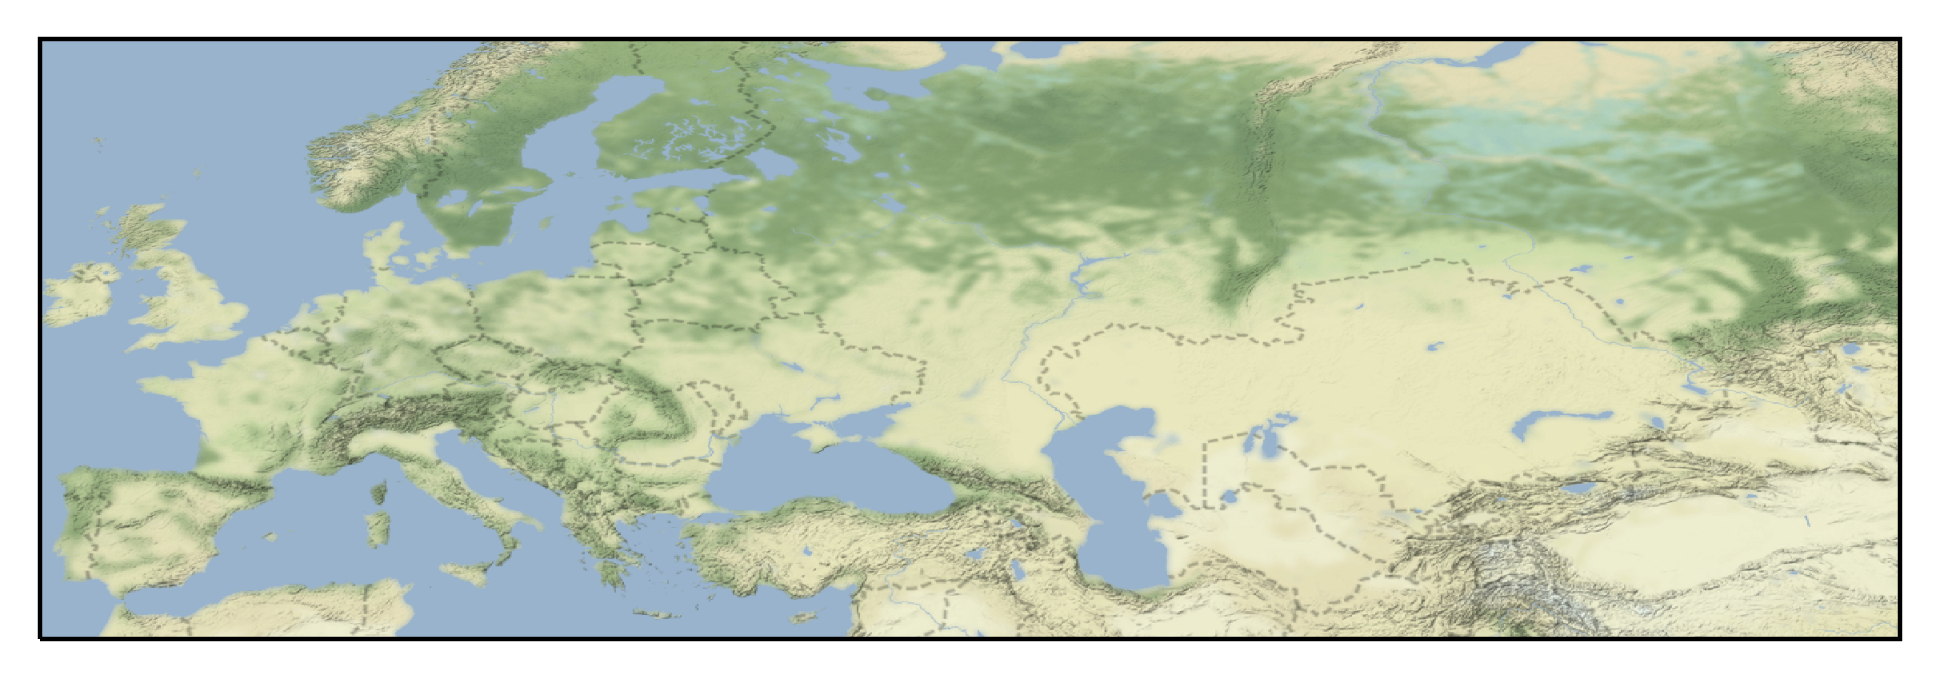

In [87]:
# Setup Map
fig = plt.figure(dpi=dpi)  
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) 
ax1.add_image(basemap, 4)

# Bounds
mb = Polygon(exp_gdf['geometry']).bounds
xb, yb = 10, 8
map_bounds = [mb[0] - xb, mb[2] + xb, mb[1] - yb, mb[3] + yb]
ax1.set_extent(map_bounds, crs=ccrs.PlateCarree()) 

In [88]:
# Plot Connections
#[ax1.add_line(connection) for connection in network_connections]

def animate_connections(i):
    # On the first frame plot the root
    if i == 0:
        ax1.add_line(root_marker)
    if i > 0:
        ax1.add_line(network_connections[i-1])
        connection = network_connections[i-1]
        dest_name  = connection.get_label()
        dest_geom  = exp_gdf["geometry"][dest_name]
        dest_state = exp_df["Mugration_Branch_Major"][dest_name]
        dest_geo   = exp_df["Mugration_" + geo_attr][dest_name]
        dest_color = colors_dict["branch_major"][dest_state] 
        dest_size  = sizes_dict[geo_attr.lower()][dest_geo] 
        dest_marker = lines.Line2D(
                [dest_geom.x], 
                [dest_geom.y],
                marker="o",
                markerfacecolor=dest_color, 
                markeredgecolor="black", 
                markeredgewidth=0.5,
                markersize=dest_size, 
                zorder=3,
            )
        ax1.add_line(dest_marker)

#for i in range(0,10):
#    animate_connections(i)
# Save the animation
anim = animation.FuncAnimation(fig, animate_connections, interval=500, frames=len(network_connections) + i, repeat=True)    
out_path = os.path.join(outdir, SCRIPT_NAME + "_connections.gif")
anim.save(out_path, writer='imagemagick')

IndexError: list index out of range

In [ ]:
bias_df = experiment_df[experiment_df["bias"] == "Geocoding"]
for experiment in bias_df.iterrows():    
    
    # Get experiment-specific variables
    exp_tree = copy.deepcopy(clade)
    geo_attr = experiment[1]["geo_attr"]
    geo_filter_attr = experiment[1]["geo_filter_attr"]
    geo_remove = experiment[1]["geo_remove"]
    arrow_style = experiment[1]["arrow_style"]
    exp_df = copy.deepcopy(clade_df)
    
    # Convert dataframe to geopandas
    geometry = []
    for rec in exp_df.iterrows():
        sample = rec[0]
        x = exp_df["Mugration_" + geo_attr + "_Lon"][sample] 
        y = exp_df["Mugration_" + geo_attr + "_Lat"][sample]
        geometry.append(shapely.geometry.Point(x,y))

    exp_gdf = geopandas.GeoDataFrame(exp_df, crs=CRS, geometry=geometry)    
    
        
    # Prune/filter nodes
    for c in exp_tree.get_terminals():
        c_geo = tree_df["Mugration_" + geo_filter_attr][c.name]
        if c_geo == geo_remove:
            exp_tree.prune(c)   
    
    # ----------------------------------------------------------
    # Prep Plot Data
    network = tree2network(exp_tree)
    network_coord_uniq = []
    network_markers = []
    network_connect_uniq = []    
    network_connections = []
    
    for connection in network:
        origin_name = connection[0].name
        dest_name = connection[1].name

        # Geometry
        origin_geom = exp_gdf["geometry"][origin_name]
        dest_geom = exp_gdf["geometry"][dest_name]
        
        # Aesthetic
        dest_state = exp_df["Mugration_Branch_Major"][dest_name]
        dest_color = colors_dict["branch_major"][dest_state] 
        
        # Create the marker
        if dest_geom not in network_coord_uniq:
            network_coord_uniq.append(dest_geom)
                    
            marker = lines.Line2D(
                [dest_geom.x], 
                [dest_geom.y],
                marker="o",
                markerfacecolor=dest_color, 
                markeredgecolor="black", 
                markeredgewidth=0.5,
                markersize=5, 
                zorder=3,
            )
        
            network_markers.append(marker)
            
        dest_confidence = exp_df["Mugration_" + geo_attr + "_Confidence"][dest_name]
        if dest_confidence < MUG_CONF_THRESH:
            dest_color = "white"
        
        # Create the connection line
        if [origin_geom, dest_geom] not in network_connect_uniq and origin_geom != dest_geom:
            network_connect_uniq.append([origin_geom, dest_geom])
            
            connection = lines.Line2D(
               [origin_geom.x, dest_geom.x], 
               [origin_geom.y, dest_geom.y],  
               color=dest_color,
               lw=1.5,
               transform=ccrs.Geodetic(),
               path_effects=[
                   patheffects.Stroke(linewidth=2, foreground='black'),
                   patheffects.Normal(),
               ],
               zorder=1,
            )        
            network_connections.append(connection)


    # Get the root data
    root_geom = exp_gdf["geometry"][clade.root.name]
    root_state = exp_df["Mugration_Branch_Major"][clade.root.name]
    root_color = colors_dict["branch_major"][root_state] 
    root_marker = lines.Line2D([root_geom.x], 
                [root_geom.y],
                marker="*",
                markerfacecolor=root_color, 
                markeredgecolor="black", 
                markeredgewidth=0.5,
                markersize=10, 
            )
    network_markers.append(root_marker)
    
    # ----------------------------------------------------------
    # Setup Plot
    fig = plt.figure(dpi=dpi)  
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) 
    ax1.add_image(basemap, 1)
    
    # Set Map Extent
    mb = Polygon(exp_gdf['geometry']).bounds
    xb = 10
    yb = 8
    map_bounds = [mb[0] - xb, mb[2] + xb, mb[1] - yb, mb[3] + yb]
    ax1.set_extent(map_bounds, crs=ccrs.PlateCarree()) 
    
    # Plot Markers
    #[ax1.add_line(marker) for marker in network_markers]
    
    # Plot Connections
    #[ax1.add_line(connection) for connection in network_connections]
        
    def animate_connections(i):
        # On the first frame plot the root
        if i == 0:
            ax1.add_line(root_marker)
        if i > 0:
            ax1.add_line(network_connections[i-1])

    # Save the animation
    anim = animation.FuncAnimation(
           fig, animate_connections, interval=500, frames=4, repeat=True)    
    #fig.show()
    anim.save("connections" + '.gif', writer='imagemagick')
        
    # Title
    ax1.set_title(experiment[1]["title"], fontsize=6)
    break
             

In [ ]:
        """if y[1] > y[0]:    
            y_h = y[1] - y[0]
            arrow_y1 = y[0] + (y_h * 0.95)
            arrow_y2 = y[0] + (y_h * 0.98)
            arrow_h = arrow_y2 - arrow_y1
        else:
            y_h = y[0] - y[1]
            arrow_y1 = y[1] + (y_h * 0.95)
            arrow_y2 = y[1] + (y_h * 0.98)
            arrow_h = arrow_y2 - arrow_y1

        arrow_x1 = findXPoint(x[0], x[1], y[0], y[1], arrow_y1)
        arrow_x2 = findXPoint(x[0], x[1], y[0], y[1], arrow_y2)
        arrow_w = arrow_x2 - arrow_x1

        ax1.arrow(
            arrow_x1, arrow_y1, arrow_w, arrow_h,
            color=line.get_color(),
            lw=line.get_lw(), 
            length_includes_head=True, 
            head_width=1,
            path_effects=line.get_path_effects(),
            zorder=2,
        )"""

In [ ]:
fig = plt.figure(dpi=dpi)  
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Set Map Extent
mb = Polygon(exp_gdf['geometry']).bounds
xb = 10
yb = 8
map_bounds = [mb[0] - xb, mb[2] + xb, mb[1] - yb, mb[3] + yb]
ax1.set_extent(map_bounds, crs=ccrs.PlateCarree()) 

for marker in network_markers:
    ax1.add_line(marker)

In [ ]:
# I want to animate a point moving along a line in 4 points
fig, ax = plt.subplots(figsize=(3, 3))
ax.set_aspect('equal')
#ax.grid(False)
#ax.axis('off')

#scat = ax.scatter(x,y)
#ax.set_xlim(0,4)
#ax.set_ylim(0,4)

def animate(i):
    x = i
    y = i
    ax.scatter(x,y)
    
# Save the animation
anim = FuncAnimation(
    fig, animate, interval=500, frames=4, repeat=True)    
fig.show()
anim.save("test" + '.gif', writer='imagemagick')

---
# 2. Objective 2

---
# Export

## Dataframe

In [ ]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

## Timetrees

In [ ]:
# Phyloxml
tt_copy = copy.deepcopy(tt)
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_timetree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Divtrees

In [ ]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Phyloxml
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_divtree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Augur JSON

In [ ]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt_copy.tree, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["NODE0"])

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

## Auspice JSON

In [ ]:
auspice_dict = auspice_export(
    tree=tt_copy.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")